In [1]:
info = {}
info['version'] = !python -V
info['directory'] = !pwd
info['python_path'] = !which python

In [2]:
info

{'version': ['Python 3.8.3'],
 'directory': ['/Users/tim/genecentrix_drive/python_scripts'],
 'python_path': ['/opt/anaconda3/envs/nlp/bin/python']}

## PIP INSTALLATION

In [3]:
req = ['pandas','elsapy','requests','matplotlib','requests','bs4','nltk','html5lib']
for i in req:
    !pip install {i}

  Using cached https://files.pythonhosted.org/packages/10/ed/7e8b97591f6f456174139ec089c769f89a94a1a4025fe967691de971f314/bs4-0.0.1.tar.gz
  Created wheel for bs4: filename=bs4-0.0.1-cp37-none-any.whl size=1273 sha256=e1f8904b0f5d50de5448139d18b7db3d90598a930a1434d2264058d38be14f0b
  Stored in directory: /Users/tim/Library/Caches/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4


## LIBRARIES USED

In [3]:
import pandas as pd
import os
import elsapy
import string
import matplotlib.pyplot as plt
from elsapy.elsclient import ElsClient
from elsapy.elsdoc import FullDoc, AbsDoc
import json
import requests
# import nltk
# from bs4 import BeautifulSoup as bs
# from nltk.stem.porter import PorterStemmer as stemmer
# from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer as lem
# from nltk.corpus import wordnet
os.chdir('/Users/tim/nlp_valid')

In [4]:
## Load configuration
con_file = open("config.json")
config = json.load(con_file)
con_file.close()

In [5]:
config

{'apikey': '222a2a95a093a5c6049c145c09ed85a9'}

In [6]:
## Initialize client
client = ElsClient(config['apikey'])

In [81]:
## Scopus (Abtract) document example
# Initialize document with ID as integer
scp_doc = AbsDoc(scp_id = 84872135457)
if scp_doc.read(client):
    print ("scp_doc.title: ", scp_doc.title)
    scp_doc.write()   
else:
    print ("Read document failed.")

scp_doc.title:  Control of somatic tissue differentiation by the long non-coding RNA TINCR


In [183]:
## ScienceDirect (full-text) document example using PII
pii_doc = FullDoc(sd_pii = 'S1674927814000082')
if pii_doc.read(client):
    print ("pii_doc.title: ", pii_doc.title)
    #pii_doc.write()   
else:
    print ("Read document failed.")

pii_doc.title:  Establishing the fair allocation of international aviation carbon emission rights


In [184]:
pii_doc.data['originalText']

"serial JL 312041 291210 291801 31 90 Advances in Climate Change Research ADVANCESINCLIMATECHANGERESEARCH 2014-12-19 2014-12-19 2015-02-20T12:58:19 1-s2.0-S1674927814000082 S1674-9278(14)00008-2 S1674927814000082 10.1016/j.accre.2014.08.001 S300 S300.2 FULL-TEXT 1-s2.0-S1674927815X00025 2015-05-15T07:03:33.727831-04:00 0 0 20140901 20140930 2014 2014-12-19T17:40:00.029325Z articleinfo articletitlenorm authfirstinitialnorm authfirstsurnamenorm cid cids contenttype copyright crossmark dateloaded dateloadedtxt datesearch datesort dateupdated dco docsubtype doctype doi eid ewtransactionid hubeid indexeddate issfirst issn issnnorm issuelist itemstage itemtransactionid itemweight oauserlicense openaccess openarchive pg pgfirst pglast pii piinorm pubdateend pubdatestart pubdatetxt pubyr sectiontitle sortorder srctitle srctitlenorm srctype ssids alllist content oa subj subheadings tomb volfirst volissue volumelist webpdf webpdfpagecount yearnav figure table body mmlmath acknowledge affil artic

In [16]:
url = 'https://api.elsevier.com/content/search/scopus?start=25&count=25&query=lipitor%20targets&apiKey=222a2a95a093a5c6049c145c09ed85a9'

'https://api.elsevier.com/content/search/scopus?start=25&count=25&query=lipitor%20targets&apiKey=222a2a95a093a5c6049c145c09ed85a9'

In [17]:
b = {}
for i in results['pubmed_id']:
    b[str(i)] = requests.get(f'https://api.elsevier.com/content/article/pubmed_id/{i}')

NameError: name 'results' is not defined

In [7]:

def get_summary(search_string,apikey):
    search_string = search_string.replace(' ','%20')
    url = f'https://api.elsevier.com/content/search/scopus?start=0&count=25&query={search_string}&apiKey={apikey}'
    res = requests.get(url)
    x = json.loads(res.text)
    summary = {}
    try:
        summary['total_results'] = int(x['search-results']['opensearch:totalResults'])
        summary['search_terms'] = x['search-results']['opensearch:Query']['@searchTerms']
    except Exception as e:
        summary['total_results'] = 0
        summary['search_terms'] = search_string
        print(e)
    
    summary['link_used'] = url
    summary['apikey'] = apikey
    return summary

def get_urls(summary):
    #url generation
    search_string = summary['search_terms'].replace(' ','%20')
    apikey = summary['apikey']
    base = f'https://api.elsevier.com/content/search/scopus?start=0&count=25&query={search_string}&apiKey={apikey}'
    x=0
    n=round(summary['total_results']/25)
    urls = []
    for i in range(n+1):
        url = f'https://api.elsevier.com/content/search/scopus?start={x}&count=25&query={search_string}&apiKey={apikey}'
        x+=25
        urls.append(url)
    return(urls)

def get_res(url):
    error_collection=[]
    res = requests.get(url)
    x = json.loads(res.text)
    ids = {}
    try:
        results = pd.DataFrame(x['search-results']['entry'])
        ids = pd.DataFrame(x['search-results']['entry'])['dc:identifier']
        scopus_ids = ",".join(format(i.split(':')[1])for i in ids).split(',')
        results['dc:identifier'] = scopus_ids
        return results
    except Exception as e:
        print (url,e)
        return  pd.DataFrame()
    
def final_result(search_string):
    apikey = '222a2a95a093a5c6049c145c09ed85a9'
    summary = get_summary(search_string,apikey)
    urls = get_urls(summary)
    final_result = []
    for url in urls:
        res = get_res(url)
        final_result.append(res)
    out = pd.concat(final_result)
    return out

In [36]:
def final_final(search_string):
    #search_string = input('please enter a valid search string \n')
    result = final_result(search_string)
    result = result.reset_index(drop=True)
    return result

In [39]:
name_list = ["zolinza intestinal cancer",'kbgaierbvigbe']
res = {}
for drug in name_list:
    res[drug] = final_final(drug)

https://api.elsevier.com/content/search/scopus?start=0&count=25&query=kbgaierbvigbe&apiKey=222a2a95a093a5c6049c145c09ed85a9 'dc:identifier'


In [ ]:
to_save = res['zolinza intestinal cancer']

In [48]:
pd.DataFrame.to_csv(to_save,'/Users/tim/Desktop/temp.csv')

# column mapping
#######  '@_fa' 
#######  'link'
#######  'prism:url'
#######  'dc:identifier' : scopus id
#######  'eid'
#######  'dc:title' : title
#######  'dc:creator' : first_author
#######  'prism:publicationName' : journal
#######  'prism:issn'
#######  'prism:eIssn'
#######  'prism:volume'
#######  'prism:pageRange'
#######  'prism:coverDate'
#######  'prism:coverDisplayDate'
#######  'prism:doi' : doi
#######  'pii' : something to pull paper from
#######  'citedby-count'
#######  'affiliation'
#######  'pubmed-id'
#######  'prism:aggregationType'
#######  'subtype'
#######  'subtypeDescription'
#######  'article-number'
#######  'source-id'
#######  'openaccess' : open access = 1
#######  'openaccessFlag'
#######  'prism:issueIdentifier'
#######  'prism:isbn'

In [32]:
result

,@_fa,link,prism:url,dc:identifier,eid,dc:title,dc:creator,prism:publicationName,prism:issn,prism:eIssn,...,prism:aggregationType,subtype,subtypeDescription,source-id,openaccess,openaccessFlag,pubmed-id,article-number,pii,prism:isbn
0,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,85071138336,2-s2.0-85071138336,Key actors in cancer therapy: Epigenetic modif...,Akar R.,Turkish Journal of Biology,13000152,13036092,...,Journal,re,Review,4700152284,1,True,NaN,NaN,NaN,NaN
1,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,85053082829,2-s2.0-85053082829,Histone deacetylase inhibitors and diabetic ki...,Hadden M.,International Journal of Molecular Sciences,16616596,14220067,...,Journal,re,Review,25879,1,True,30189630,2630,NaN,NaN
2,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,85033673757,2-s2.0-85033673757,Synthesis and biological evaluation of Santacr...,Randino R.,Bioorganic and Medicinal Chemistry,09680896,14643391,...,Journal,ar,Article,25786,0,False,29100734,NaN,S0968089617316917,NaN
3,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,85019200369,2-s2.0-85019200369,MYC—master regulator of the cancer epigenome a...,Poole C.J.,Genes,NaN,20734425,...,Journal,re,Review,19700188368,1,True,NaN,142,NaN,NaN
4,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,85011283293,2-s2.0-85011283293,Epigenetics in cancer stem cells,Toh T.,Molecular Cancer,NaN,14764598,...,Journal,re,Review,12429,1,True,28148257,29,NaN,NaN
5,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,84959526162,2-s2.0-84959526162,"The effects of Rpd3 on fly metabolism, health,...",Woods J.K.,Experimental Gerontology,05315565,18736815,...,Journal,ar,Article,29003,0,False,26927903,NaN,S0531556516300560,NaN
6,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,84988231095,2-s2.0-84988231095,Histone Deacetylase Inhibitors in Medical Ther...,Chun P.,Medical Epigenetics,NaN,NaN,...,Book,ch,Chapter,21100780032,0,False,NaN,NaN,B978012803239800034X,"[{'@_fa': 'true', '$': '9780128032404'}, {'@_f..."
7,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,84941765292,2-s2.0-84941765292,Histone deacetylases in bone development and s...,Bradley E.,Physiological Reviews,00319333,15221210,...,Journal,ar,Article,24004,0,False,26378079,NaN,NaN,NaN
8,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,84930868061,2-s2.0-84930868061,Histone deacetylase inhibitors in hematologica...,Chun P.,Archives of Pharmacal Research,02536269,19763786,...,Journal,ar,Article,19958,0,False,25653088,NaN,NaN,NaN
9,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,84918836720,2-s2.0-84918836720,HDAC inhibitor-induced drug resistance involvi...,Ni X.,Oncology Letters,17921074,17921082,...,Journal,ar,Article,19700176021,1,True,NaN,NaN,NaN,NaN


In [34]:
search_string = 'Zolinza Targets intestinal cancer'
a = get_summary(search_string,config['apikey'])
a

{'total_results': 54,
 'search_terms': 'Zolinza Targets intestinal cancer',
 'link_used': 'https://api.elsevier.com/content/search/scopus?start=0&count=25&query=Zolinza%20Targets%20intestinal%20cancer&apiKey=222a2a95a093a5c6049c145c09ed85a9',
 'apikey': '222a2a95a093a5c6049c145c09ed85a9'}

In [35]:
get_urls(a)

['https://api.elsevier.com/content/search/scopus?start=0&count=25&query=Zolinza%20Targets%20intestinal%20cancer&apiKey=222a2a95a093a5c6049c145c09ed85a9',
 'https://api.elsevier.com/content/search/scopus?start=25&count=25&query=Zolinza%20Targets%20intestinal%20cancer&apiKey=222a2a95a093a5c6049c145c09ed85a9',
 'https://api.elsevier.com/content/search/scopus?start=50&count=25&query=Zolinza%20Targets%20intestinal%20cancer&apiKey=222a2a95a093a5c6049c145c09ed85a9']

In [16]:
b = final_result(search_string)
b = b.reset_index(drop=True)

In [17]:
b

,@_fa,link,prism:url,dc:identifier,eid,dc:title,dc:creator,prism:publicationName,prism:issn,prism:eIssn,...,prism:aggregationType,subtype,subtypeDescription,source-id,openaccess,openaccessFlag,pubmed-id,article-number,pii,prism:isbn
0,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,85071138336,2-s2.0-85071138336,Key actors in cancer therapy: Epigenetic modif...,Akar R.,Turkish Journal of Biology,13000152,13036092,...,Journal,re,Review,4700152284,1,True,NaN,NaN,NaN,NaN
1,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,85053082829,2-s2.0-85053082829,Histone deacetylase inhibitors and diabetic ki...,Hadden M.,International Journal of Molecular Sciences,16616596,14220067,...,Journal,re,Review,25879,1,True,30189630,2630,NaN,NaN
2,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,85033673757,2-s2.0-85033673757,Synthesis and biological evaluation of Santacr...,Randino R.,Bioorganic and Medicinal Chemistry,09680896,14643391,...,Journal,ar,Article,25786,0,False,29100734,NaN,S0968089617316917,NaN
3,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,85019200369,2-s2.0-85019200369,MYC—master regulator of the cancer epigenome a...,Poole C.J.,Genes,NaN,20734425,...,Journal,re,Review,19700188368,1,True,NaN,142,NaN,NaN
4,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,85011283293,2-s2.0-85011283293,Epigenetics in cancer stem cells,Toh T.,Molecular Cancer,NaN,14764598,...,Journal,re,Review,12429,1,True,28148257,29,NaN,NaN
5,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,84959526162,2-s2.0-84959526162,"The effects of Rpd3 on fly metabolism, health,...",Woods J.K.,Experimental Gerontology,05315565,18736815,...,Journal,ar,Article,29003,0,False,26927903,NaN,S0531556516300560,NaN
6,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,84988231095,2-s2.0-84988231095,Histone Deacetylase Inhibitors in Medical Ther...,Chun P.,Medical Epigenetics,NaN,NaN,...,Book,ch,Chapter,21100780032,0,False,NaN,NaN,B978012803239800034X,"[{'@_fa': 'true', '$': '9780128032404'}, {'@_f..."
7,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,84941765292,2-s2.0-84941765292,Histone deacetylases in bone development and s...,Bradley E.,Physiological Reviews,00319333,15221210,...,Journal,ar,Article,24004,0,False,26378079,NaN,NaN,NaN
8,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,84930868061,2-s2.0-84930868061,Histone deacetylase inhibitors in hematologica...,Chun P.,Archives of Pharmacal Research,02536269,19763786,...,Journal,ar,Article,19958,0,False,25653088,NaN,NaN,NaN
9,true,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,84918836720,2-s2.0-84918836720,HDAC inhibitor-induced drug resistance involvi...,Ni X.,Oncology Letters,17921074,17921082,...,Journal,ar,Article,19700176021,1,True,NaN,NaN,NaN,NaN


In [18]:
d = b['pii'].dropna()
len(d)

17

In [19]:
c = b['prism:doi'].dropna()
len(c)

49

In [20]:
f = {}
for i in d:
    data = FullDoc(sd_pii = i)
    if data.read(client):
        f[i] = 'Paper found'
    else:
        f[i] = 'No full text article found'

In [21]:
e = {}
for i in c:
    data = FullDoc(doi = i)
    if data.read(client):
        e[i] = 'paper found'
    else:
        e[i] = 'No full text article found'

In [752]:
col = 0
for i in e.values():
    if i == 'No full text article found':
        col += 1
print(295-col)

54


In [731]:
len(d)

42

In [23]:
pd.DataFrame.from_dict(e,orient='index')

,0
10.3906/biy-1903-39,No full text article found
10.3390/ijms19092630,No full text article found
10.1016/j.bmc.2017.10.026,paper found
10.3390/genes8050142,No full text article found
10.1186/s12943-017-0596-9,No full text article found
10.1016/j.exger.2016.02.015,paper found
10.1016/B978-0-12-803239-8.00034-X,paper found
10.1152/physrev.00004.2015,No full text article found
10.1007/s12272-015-0571-1,No full text article found
10.3892/ol.2014.2714,No full text article found


In [24]:
pd.DataFrame.from_dict(f,orient='index')

,0
S0968089617316917,Paper found
S0531556516300560,Paper found
B978012803239800034X,Paper found
LABINVEST201487,No full text article found
S0959804914006005,Paper found
S0093775413001310,Paper found
S2152265013001110,Paper found
S0006295212000718,Paper found
S0968089611009771,Paper found
NRC3130,No full text article found


In [25]:
b[['pii','prism:doi']]

,pii,prism:doi
0,NaN,10.3906/biy-1903-39
1,NaN,10.3390/ijms19092630
2,S0968089617316917,10.1016/j.bmc.2017.10.026
3,NaN,10.3390/genes8050142
4,NaN,10.1186/s12943-017-0596-9
5,S0531556516300560,10.1016/j.exger.2016.02.015
6,B978012803239800034X,10.1016/B978-0-12-803239-8.00034-X
7,NaN,10.1152/physrev.00004.2015
8,NaN,10.1007/s12272-015-0571-1
9,NaN,10.3892/ol.2014.2714


In [763]:
e = pd.DataFrame.from_dict(e,orient = 'index' ,columns = ['paper']).reset_index()

In [762]:
f = pd.DataFrame.from_dict(f,orient = 'index' ,columns = ['paper']).reset_index()

In [ ]:
b[['pii','prism:doi']].merge(e, )

In [764]:
e

,index,paper
0,10.1038/s41467-019-13690-5,No full text article found
1,10.1038/s41398-020-0800-3,No full text article found
2,10.1038/s41398-020-0705-1,No full text article found
3,10.1002/sim.8524,No full text article found
4,10.1186/s12859-020-03583-6,No full text article found
...,...,...
278,10.1136/jamia.2010.004366,No full text article found
279,10.1002/9780470669716.ch2,No full text article found
280,10.1093/bioinformatics/btq126,No full text article found
281,10.1093/bioinformatics/btp435,No full text article found


In [26]:
e = []
for pii in b['pii'].dropna():
    collector = []
    data = FullDoc(sd_pii = pii)
    if data.read(client):
        collector.append(data)
        collector.append(pii)
        collector.append(data.title)
        if str(type(data.data['originalText']))[8:-2] == 'str':
            collector.append('fullText')
        else:
            collector.append('noFullText')
    else:
        collector.append('noPaperFound')
        collector.append(pii)
        collector.append('noTitle')
        collector.append('noText')
    e.append(collector)

In [27]:
e=pd.DataFrame(e)

In [28]:
print(f'{e.shape[0]} papers have pii')

17 papers have pii


In [30]:
e

,0,1,2,3
0,<elsapy.elsdoc.FullDoc object at 0x11d022970>,S0968089617316917,Synthesis and biological evaluation of Santacr...,noFullText
1,<elsapy.elsdoc.FullDoc object at 0x11beb7a60>,S0531556516300560,"The effects of Rpd3 on fly metabolism, health,...",noFullText
2,<elsapy.elsdoc.FullDoc object at 0x11beb7c10>,B978012803239800034X,Chapter 34 Histone Deacetylase Inhibitors in M...,noFullText
3,noPaperFound,LABINVEST201487,noTitle,noText
4,<elsapy.elsdoc.FullDoc object at 0x11cf78d90>,S0959804914006005,Review of therapeutic drug monitoring of antic...,noFullText
5,<elsapy.elsdoc.FullDoc object at 0x10f03b7c0>,S0093775413001310,Novel Agents for Multiple Myeloma to Overcome ...,noFullText
6,<elsapy.elsdoc.FullDoc object at 0x10f076e80>,S2152265013001110,Hepatosplenic γδ T-cell Lymphoma: An Overview,noFullText
7,<elsapy.elsdoc.FullDoc object at 0x11cf788e0>,S0006295212000718,Acute sensitization of colon cancer cells to i...,noFullText
8,<elsapy.elsdoc.FullDoc object at 0x11cceb8e0>,S0968089611009771,"Synthesis and biochemical analysis of 2,2,3,3,...",noFullText
9,noPaperFound,NRC3130,noTitle,noText


In [37]:
text = e[e[3]=='fullText'][0][11].data['originalText']

In [36]:
e[e[3]=='fullText'][0][11].title

'A novel approach to detect resistance mechanisms reveals FGR as a factor mediating HDAC inhibitor SAHA resistance in B-cell lymphoma'

In [22]:
sr= stopwords.words('english')
clean_tokens = tokens[:]
for token in tokens:
    if token in stopwords.words('english'):
        clean_tokens.remove(token)
freq = nltk.FreqDist(clean_tokens)
for key,val in freq.items():
    print(str(key) + ':' + str(val))

New:131
York:181
University:101
-:30
Wikipediadocument.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"2dea5bbc-8ce4-4f1f-b5bd-1707c4222aef","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"New_York_University","wgTitle":"New:1
University","wgCurRevisionId":967484404,"wgRevisionId":967484404,"wgArticleId":7954455,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Webarchive:1
template:2
wayback:2
links","All:1
articles:32
dead:7
external:7
links","Articles:1
links:3
February:20
2018","Articles:1
permanently:2
links","Wikipedia:1
indefinitely:2
semi-protected:2
pages","Use:1
mdy:2
dates:2
September:28
2018","Good:1
a

theInstitute:2
Arts,:2
fine:1
arts,:3
James:2
1:8
78th:1
Street.[104]NYU:1
Deutsches:1
Haus,La:1
Maison:2
Française,Casa:1
Italiana:2
Zerilli:2
Marimò,:1
Glucksman:1
Ireland:1
House,:1
theKing:1
Juan:1
Carlos:1
I:1
SpainCenter,:1
theHagop:1
KevorkianCenter,:1
Africa:1
House:1
China:2
House.[105]Global:1
sitesNYU:1
host:2
forstudy:1
awayprograms,:1
referred:2
Centers.:1
2012[update],:1
sites:4
Africa,:1
Asia:8
Middle:1
Australia,:1
Europe,:1
South:1
academic-year:2
summer:2
study:5
away:3
D.C.[106]One:1
noteworthy:1
57-acre:1
(230,000:1
Florence,:2
atVilla:1
LaPietrain:1
Italy.:1
estate:1
bequeathed:1
SirHarold:1
Actonto:1
1994,:1
history.[107]In:1
spring:1
Parismoved:1
formerly:1
occupied:1
theÉcole:1
Spéciale:1
des:1
Travaux:1
Publics(ESTP:1
Paris),:1
theQuartier:1
Latin,:1
whereNYU:1
Lawalso:1
EU:1
Regulatory:1
Policy:2
Clinic:1
partnership:2
withHEC:1
Paristaught:1
byAlberto:1
AlemannoandVincent:1
Chauvet.[108]In:1
Centers,:2
maintains:1
Initiative:1
Institutes,:2
9:1
Berlin,:1
Lond

FourthPresident:1
Israel,:1
chief:1
scientist:2
theIsrael:1
Defense:1
Department;Tandon'38,:1
'41Jonas:1
Salk,:1
biologist;:1
creator:1
thepolio:1
vaccine;:1
theSalk:1
Institute;Medicine'39Martin:1
Scorsese,:1
Italian-American:1
filmmaker,:2
actor;AFI:1
Life:2
Achievement:1
Awardwinner,:3
20-timeAcademy:1
23-timeBAFTAwinner,:1
11-timeGolden:1
GlobeswinnerCAS'64,Tisch'66Spike:1
Lee,:1
producer;:2
two-timeAcademy:2
Awardwinner;:9
two-timeEmmy:1
Awardwinner;Tisch'83Ang:1
LeeOBS,:1
Taiwanese:1
director;:1
three-timeAcademy:2
two-timeGolden:1
Lionwinner;Tisch'83Oliver:1
Stone,:1
director,:2
producer,:1
writer;:1
six-timeGolden:1
Globes:1
Awardwinner;Tisch'71Alan:1
Menken,:1
composer,:1
songwriter,:2
record:1
8-timeAcademy:1
11Grammy:1
Awardswinner,:1
aTony:1
Awardwinner;Steinhart'71Alec:1
Baldwin,:1
actor,:2
writer,:1
comedian:1
philanthropist;:1
three-timeEmmy:1
three-timeGolden:2
Globewinner;Tisch'94Angelina:1
Jolie,:1
actress:1
humanitarian;:1
Globe:3
Special:1
Envoy:1
High:1
Commissione

ArchivesUnion:1
SquareUniversity:1
VillageWashington:1
MewsWashington:1
ParkWashington:1
VillageWunsch:1
BuildingNYU:1
ParisNYU:1
LondonNYU:1
FlorenceCultureNYU:1
culturePeopleList:1
alumniList:1
facultyList:1
honorary:1
recipientsList:1
UniversityList:1
staffSchoolsUndergraduateCollege:1
ScienceLiberal:1
StudiesNursingIndividualized:1
StudyEngineeringSocial:1
WorkPublic:1
ServiceMathematical:1
SciencesProfessional:1
StudiesCulture,:1
DevelopmentBusinessArtsNYU:1
DhabiNYU:1
ShanghaiGraduateDentistryMathematical:1
SciencesArts:1
ScienceAncient:1
WorldFine:1
ArtsEngineeringPublic:1
ServiceProfessional:1
StudiesLawMedicineSocial:1
WorkLibraryNew:1
LibrariesElmer:1
LibraryLifeEucleian:1
SocietyGraduate:1
CommitteeHistory:1
NYUNYU:1
LocalPhilomathean:1
SocietyThe:1
PlagueRed:1
SocietyStudent:1
CouncilWashington:1
NewsWNYU-FMLinks:1
articlesvteAssociation:1
UniversitiesPublicArizonaCaliforniaBerkeleyDavisIrvineLos:1
AngelesSan:1
DiegoSanta:1
BarbaraSanta:1
CruzColoradoFloridaGeorgia:1
TechIl

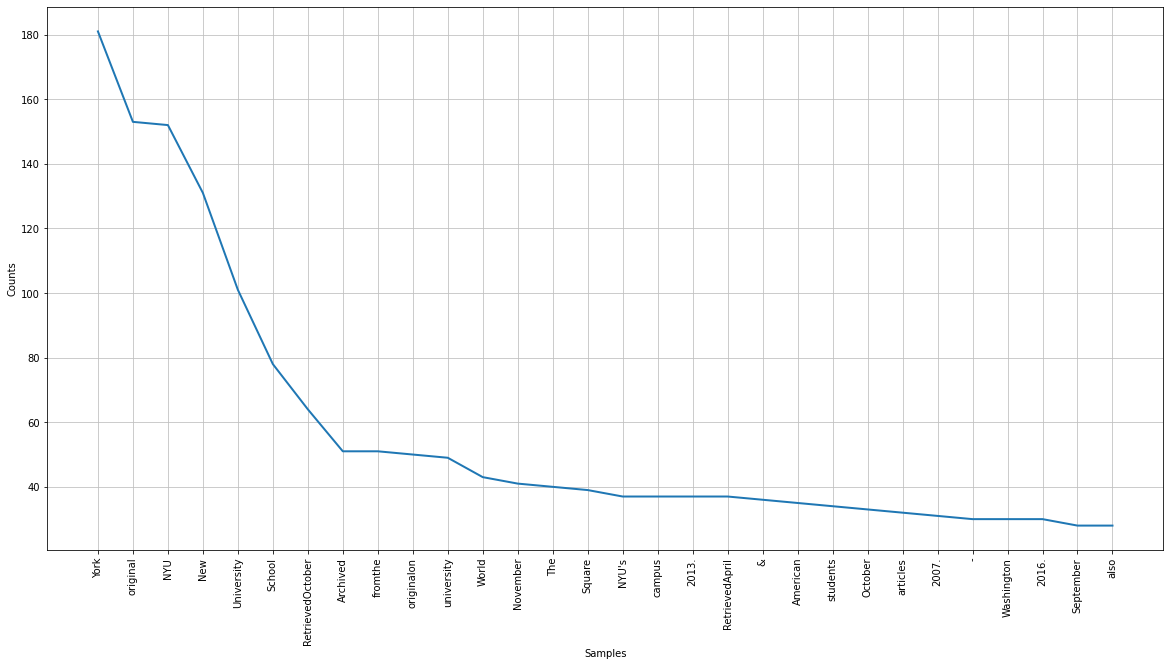

In [23]:
plt.figure(figsize=(20,10))
freq.plot(30, cumulative=False)

In [34]:
!ls /Users/tim/nltk_data/corpora/stopwords/

README      dutch       german      italian     portuguese  spanish
arabic      english     greek       kazakh      romanian    swedish
azerbaijani finnish     hungarian   nepali      russian     tajik
danish      french      indonesian  norwegian   slovene     turkish


In [25]:
freq

FreqDist({'York': 181, 'original': 153, 'NYU': 152, 'New': 131, 'University': 101, 'School': 78, 'RetrievedOctober': 64, 'Archived': 51, 'fromthe': 51, 'originalon': 50, ...})

In [33]:
token_base = []
for token in tokens:
    token_base.append(stemmer().stem(token))

NameError: name 'tokens' is not defined

In [27]:
token_base

['new',
 'york',
 'univers',
 '-',
 'wikipediadocument.documentelement.classname="client-js";rlconf={"wgbreakframes":!1,"wgseparatortransformtable":["",""],"wgdigittransformtable":["",""],"wgdefaultdateformat":"dmy","wgmonthnames":["","january","february","march","april","may","june","july","august","september","october","november","december"],"wgrequestid":"2dea5bbc-8ce4-4f1f-b5bd-1707c4222aef","wgcspnonce":!1,"wgcanonicalnamespace":"","wgcanonicalspecialpagename":!1,"wgnamespacenumber":0,"wgpagename":"new_york_university","wgtitle":"new',
 'york',
 'university","wgcurrevisionid":967484404,"wgrevisionid":967484404,"wgarticleid":7954455,"wgisarticle":!0,"wgisredirect":!1,"wgaction":"view","wgusername":null,"wgusergroups":["*"],"wgcategories":["webarch',
 'templat',
 'wayback',
 'links","al',
 'articl',
 'with',
 'dead',
 'extern',
 'links","articl',
 'with',
 'dead',
 'extern',
 'link',
 'from',
 'februari',
 '2018","articl',
 'with',
 'perman',
 'dead',
 'extern',
 'links","wikipedia'

In [28]:
clean_token = token_base[:]

In [29]:
for punc in string.punctuation:
    for token in token_base:
        if punc in token:
            token_base.remove(token)
len(clean_token)

13553

In [30]:
freq = nltk.FreqDist(clean_token)

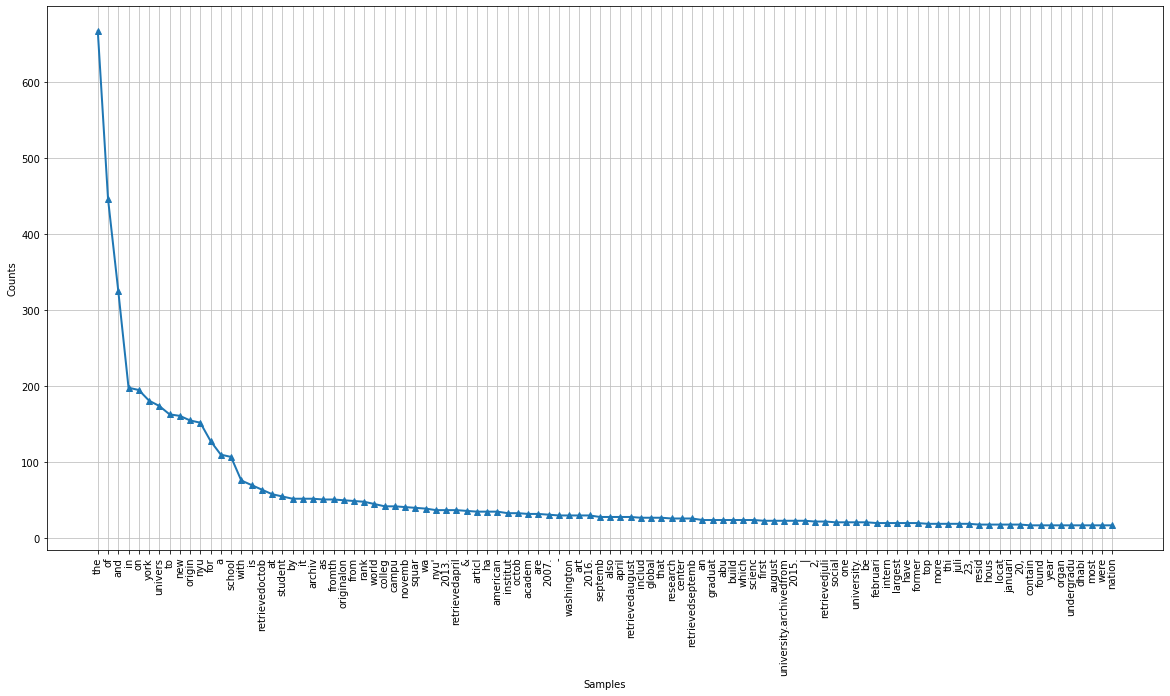

In [31]:
plt.figure(figsize=(20,10))
freq.plot(100, cumulative=False, marker='^')

In [39]:
dir(nltk)

['AbstractLazySequence',
 'AffixTagger',
 'AlignedSent',
 'Alignment',
 'AnnotationTask',
 'ApplicationExpression',
 'Assignment',
 'BigramAssocMeasures',
 'BigramCollocationFinder',
 'BigramTagger',
 'BinaryMaxentFeatureEncoding',
 'BlanklineTokenizer',
 'BllipParser',
 'BottomUpChartParser',
 'BottomUpLeftCornerChartParser',
 'BottomUpProbabilisticChartParser',
 'Boxer',
 'BrillTagger',
 'BrillTaggerTrainer',
 'CFG',
 'CRFTagger',
 'CfgReadingCommand',
 'ChartParser',
 'ChunkParserI',
 'ChunkScore',
 'Cistem',
 'ClassifierBasedPOSTagger',
 'ClassifierBasedTagger',
 'ClassifierI',
 'ConcordanceIndex',
 'ConditionalExponentialClassifier',
 'ConditionalFreqDist',
 'ConditionalProbDist',
 'ConditionalProbDistI',
 'ConfusionMatrix',
 'ContextIndex',
 'ContextTagger',
 'ContingencyMeasures',
 'CoreNLPDependencyParser',
 'CoreNLPParser',
 'Counter',
 'CrossValidationProbDist',
 'DRS',
 'DecisionTreeClassifier',
 'DefaultTagger',
 'DependencyEvaluator',
 'DependencyGrammar',
 'DependencyGrap

pos tag

In [38]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

In [39]:
token_list = pos_tag(word_tokenize(text))

In [10]:
x = pd.read_html('https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html')[0]

In [11]:
x.columns=[x.loc[0]]

In [13]:
x

,Tag,Description
1,CC,Coordinating conjunction
2,CD,Cardinal number
3,DT,Determiner
4,EX,Existential there
5,FW,Foreign word
6,IN,Preposition or subordinating conjunction
7,JJ,Adjective
8,JJR,"Adjective, comparative"
9,JJS,"Adjective, superlative"
10,LS,List item marker


In [14]:
pd.DataFrame(token_list).sort_values(by=1)

,0,1
12697,#,#
16385,#,#
12594,#,#
1560,[,$
8195,],$
...,...,...
16139,``,``
14085,``,``
3317,``,``
13552,``,``


In [40]:
tokens = word_tokenize(text)

In [41]:
clean_token = tokens[:]
for punc in string.punctuation:
    for word in tokens:
        if punc == word:
            clean_token.remove(word)

In [44]:
from nltk.tag import pos_tag
clean_list = []
for word, pos in pos_tag(clean_token):
    if pos.startswith('J'):
        tag_pos = wordnet.ADJ
    elif pos.startswith('V'):
        tag_pos = wordnet.VERB
    elif pos.startswith('N'):
        tag_pos = wordnet.NOUN
    elif pos.startswith('R'):
        tag_pos = wordnet.ADV
    else:
        pos_tag = ''
    clean_list.append(lem().lemmatize(word, tag_pos))

In [45]:
clean_stopword_removed_list = clean_list[:]
for stopword in stopwords.words('english'):
    for clean_words in clean_stopword_removed_list:
        if stopword == clean_words:
            clean_stopword_removed_list.remove(clean_words)

In [46]:
a = clean_stopword_removed_list

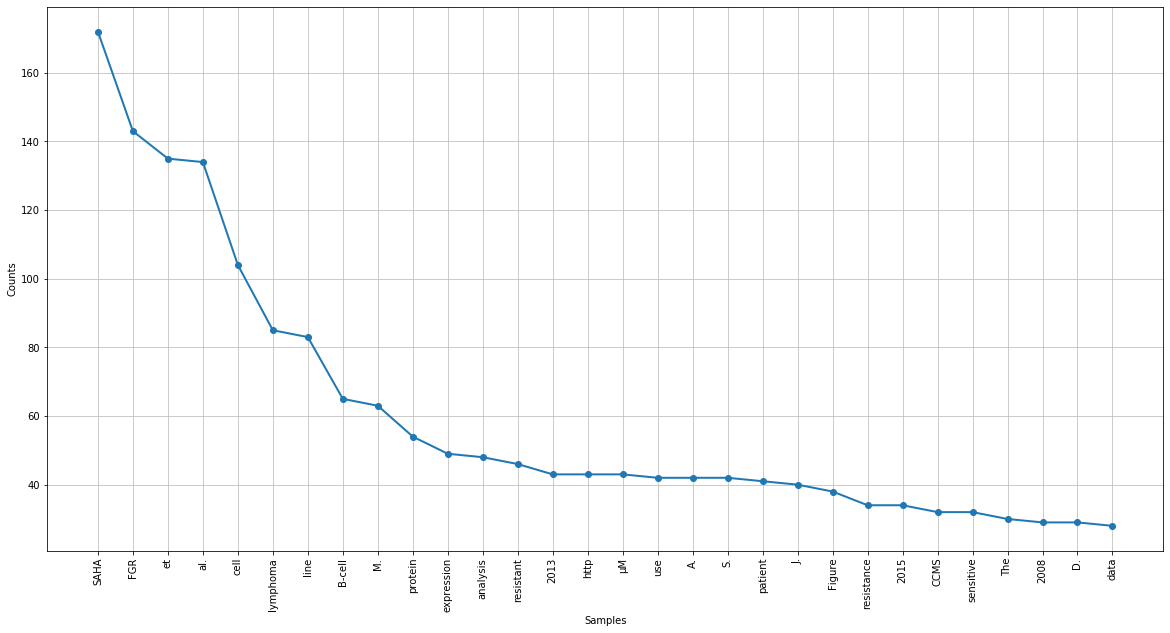

In [53]:
plt.figure(figsize = (20,10))
nltk.FreqDist(a).plot(30,cumulative=False,marker = 'o')

In [55]:
file = pd.read_csv('filelist.csv')

In [56]:
file

,File,PMCID,PMID,MID
0,PMC0012XXXXX/PMC1249490.xml,PMC1249490,15950352,UKMS5296
1,PMC0012XXXXX/PMC1249491.xml,PMC1249491,15898963,UKMS5294
2,PMC0012XXXXX/PMC1249508.xml,PMC1249508,14566027,UKMS5323
3,PMC0012XXXXX/PMC1266050.xml,PMC1266050,15200711,UKMS5373
4,PMC0012XXXXX/PMC1266051.xml,PMC1266051,15871598,UKMS5282
...,...,...,...,...
672000,PMC0073XXXXX/PMC7354058.xml,PMC7354058,30353515,NIHMS1603930
672001,PMC0073XXXXX/PMC7354103.xml,PMC7354103,25856009,EMS86579
672002,PMC0073XXXXX/PMC7354236.xml,PMC7354236,31481504,NIHMS1539041
672003,PMC0073XXXXX/PMC7354351.xml,PMC7354351,32220816,NIHMS1606061


In [45]:
requests.get('https://www.wikipedia.org').text

'<!DOCTYPE html>\n<html lang="mul" class="no-js">\n<head>\n<meta charset="utf-8">\n<title>Wikipedia</title>\n<meta name="description" content="Wikipedia is a free online encyclopedia, created and edited by volunteers around the world and hosted by the Wikimedia Foundation.">\n<script>\ndocument.documentElement.className = document.documentElement.className.replace( /(^|\\s)no-js(\\s|$)/, "$1js-enabled$2" );\n</script>\n<meta name="viewport" content="initial-scale=1,user-scalable=yes">\n<link rel="apple-touch-icon" href="/static/apple-touch/wikipedia.png">\n<link rel="shortcut icon" href="/static/favicon/wikipedia.ico">\n<link rel="license" href="//creativecommons.org/licenses/by-sa/3.0/">\n<style>\n.sprite{background-image:url(portal/wikipedia.org/assets/img/sprite-46c49284.png);background-image:linear-gradient(transparent,transparent),url(portal/wikipedia.org/assets/img/sprite-46c49284.svg);background-repeat:no-repeat;display:inline-block;vertical-align:middle}.svg-Commons-logo_sister